# Exercises for Chapter 9: Loss Functions

## 9.1 On the Bias-Variance Trade-Off and the Need for Regularization

In [1]:
# Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Reproducibility
SEED = 1
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)

In [3]:
### TASK
# Data creation
# TODO: Sample 100 observation from a uniform distribution on the interval [0, 2pi]
n = 1
X = rng.uniform(n)
# TODO: Create the target variable as pi*sin(x) plus N(0, 1)
y = rng.normal(n)

In [5]:
### TASK
# TODO: Visualize the Data and also include the ground truth data generating process

Let’s begin by exploring why more is not always better. Suppose, for illustration, that we know the underlying data-generating process, which is not the case of course in reality. We can fit different models to our data and compare how closely they match the true function. Our goal is to find a model that generalizes well, a central theme in machine learning. This means the model should not simply memorize the data, but instead capture underlying patterns that enable accurate predictions for previously unseen points. We will see that simplicity is not necessarily a drawback. This insight will motivate the regularization methods introduced in this chapter, which help prevent overfitting and improve a model’s generalization ability.

In [5]:
# Perform train-test split
train_split = int(n * 0.7)
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]

**TASK**: What is the purpose ot the above code?

In [6]:
# Turn into torch tensors for training
X_train = torch.from_numpy(X_train).float().unsqueeze(1)
X_test  = torch.from_numpy(X_test).float().unsqueeze(1)
y_train = torch.from_numpy(y_train).float().unsqueeze(1)
y_test  = torch.from_numpy(y_test).float().unsqueeze(1)

This time, we will use mini-batch training, a technique often referred to as *implicit regularization*. Instead of using the entire dataset for each gradient update, we will work with small random subsamples (mini-batches). An epoch is completed once every data point has been passed through the network exactly once.

In [7]:
# Mini-batch loader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=25, shuffle=True)

In [8]:
class NeuralNetwork(nn.Module):
    def __init__(self, architecture, hidden_act=nn.Tanh(), out_act=nn.Identity()):
        super().__init__()
        layers = []
        for i in range(len(architecture) - 2):
            layers += [nn.Linear(architecture[i], architecture[i+1]), hidden_act]
        layers += [nn.Linear(architecture[-2], architecture[-1]), out_act]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

**TASK**: What kind of neural network family can we fit using this class? Why do we use these activation functions?


In [ ]:
### TASK 
# TODO: Instantiate a simple_model with 1 hidden layers of 4 neurons and a complex one with 3 of 64 each

**TASK**: How many weights do the two neural networks have, respectively?

In [13]:
### TASK
# TODO: Set up loss function 'loss_fn

# Set up optimizer
optimizer_simple  = torch.optim.Adam(model_simple.parameters(),  lr=0.1)
optimizer_complex = torch.optim.Adam(model_complex.parameters(), lr=0.0005)

In [11]:
# Empty lists to store error values for training and testing
train_losses_simple, test_losses_simple = [], []
train_losses_complex, test_losses_complex = [], []

epochs = 10_000
for epoch in range(epochs):
    model_simple.train(); model_complex.train()

    # Perform mini batch training using samples of 25 observations each
    for xb, yb in train_loader:
        # simple
        optimizer_simple.zero_grad()
        loss_s = loss_fn(model_simple(xb), yb)
        loss_s.backward()
        optimizer_simple.step()

        # complex
        optimizer_complex.zero_grad()
        loss_c = loss_fn(model_complex(xb), yb)
        loss_c.backward()
        optimizer_complex.step()

    if epoch % 100 == 0:
        with torch.inference_mode():
            model_simple.eval(); model_complex.eval()
            train_losses_simple.append(loss_fn(model_simple(X_train), y_train).item())
            test_losses_simple.append(loss_fn(model_simple(X_test),  y_test).item())
            train_losses_complex.append(loss_fn(model_complex(X_train), y_train).item())
            test_losses_complex.append(loss_fn(model_complex(X_test),  y_test).item())


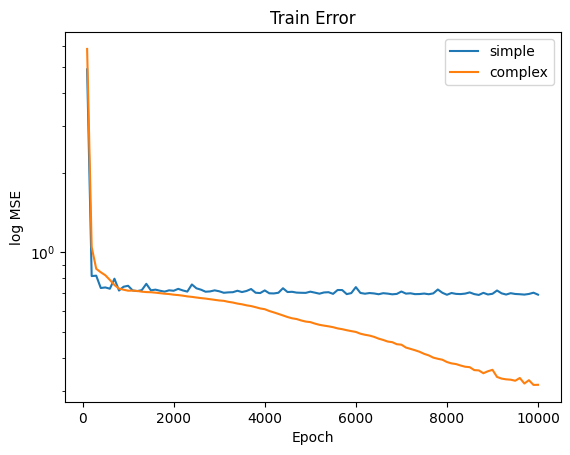

In [16]:
# We only recoreded the errors each 100 epochs, hence we need an epochs array
epoch_range = np.arange(100, epochs+1, 100)

# Plot Train losses
plt.figure()
plt.plot(epoch_range, train_losses_simple, label="simple")
plt.plot(epoch_range, train_losses_complex, label="complex")
plt.xlabel("Epoch"); plt.ylabel("log MSE")
plt.title("Train Error")
plt.yscale("log"); plt.legend(); plt.show()

**TASK**: Before running the code below: What do you see? How do you expect the test errors to behave for the simple and the complex model? Should we keep training given that the loss of the complex model is still decreasing? Why?


In [17]:
### TASK
# TODO: Perform the same analysis for the test losses

**TASK**: Can you explain what is happening here? Mention effective coutermeasures that would have prevented overfitting the complex model.

Let's visualize the model fits that our two models produce to figure out what is going on.

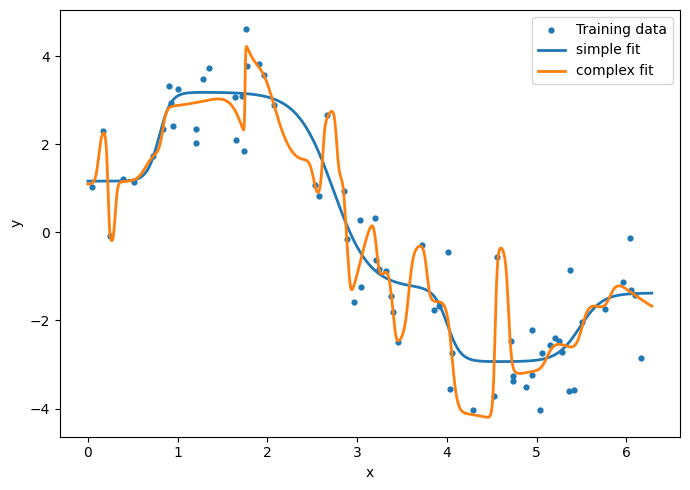

In [19]:
# Dense x for smooth curves
x_plot = np.linspace(0, 2*np.pi, 1000, dtype=np.float32)
x_plot_t = torch.from_numpy(x_plot).unsqueeze(1)

with torch.inference_mode():
    y_simple  = model_simple(x_plot_t).squeeze(1).numpy()
    y_complex = model_complex(x_plot_t).squeeze(1).numpy()

plt.figure(figsize=(7,5))
plt.scatter(X_train, y_train, s=12, label="Training data")
plt.plot(x_plot, y_simple,  linewidth=2, label="simple fit")
plt.plot(x_plot, y_complex, linewidth=2, label="complex fit")
plt.xlabel("x"); plt.ylabel("y"); plt.legend(); plt.tight_layout()
plt.show()

We can clearly see that the complex model is overfitting the data. While the simple model has learned a functional form that generalizes well (quite similar to the sine curve), the complex one places too much emphasis on outliers and produces an excessively wiggly curve. Instead of capturing the true signal of the data-generating process, it is modeling inherent noise.

## 9.2 $L_2$ Regularization

**TASK**: How do the gradients of the loss function change when L2 regularization: 

$$
\hat{\phi} = \arg\min_{\phi} \left[ \sum_{i=1}^{I} \ell_i[\mathbf{x}_i, \mathbf{y}_i] + \lambda \sum_{j} \phi_j^2 \right]
$$

is added?

*Let's apply this procedure in a practical setting!*

In [20]:
## Setup

# Imports
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

# Reproducibility
SEED = 111
rng = np.random.default_rng(SEED)
torch.manual_seed(SEED)
torch.set_default_dtype(torch.float32)

In [21]:
# Create the true underlying data-generating process
def DGP(x):
    if isinstance(x, torch.Tensor):
        return torch.sin(x)
    return np.sin(x)

In [22]:
# Training data
n_train = 20
X_train = rng.uniform(0, 2*np.pi, n_train).astype(np.float32)
y_train = (DGP(X_train) + rng.normal(0, 0.5, n_train)).astype(np.float32)

# Torch tensors
X_t = torch.from_numpy(X_train).unsqueeze(1)
y_t = torch.from_numpy(y_train).unsqueeze(1)

# Range for plotting predictions
X_range_t = torch.linspace(X_train.min(), X_train.max(), 1000).unsqueeze(1)

In [23]:
# Neural Network Class (MLP stands for Multi-layer Perceptron)
class MLP(nn.Module):
    def __init__(self, n_neurons):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, n_neurons),
            nn.Tanh(),
            nn.Linear(n_neurons, 1)
        )
    def forward(self, x):
        return self.model(x)

In [24]:
# Function which takes as input a neural network and returns its sum of squared weights
def l2_penalty(model, exclude_bias=True):
    total = 0.0
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if exclude_bias and name.endswith('bias'):
            continue
        total = total + p.pow(2).sum()
    return total

**TASK**: Explain how the above function works.

In [25]:
# Define hyperparameters
n_hidden_neurons = 14 # (shallow neural network)
loss_fn = nn.MSELoss()
epochs = 1000
lr = 0.1

In [26]:
# Create a grid of lambda values
lambdas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]

As we have access to the underlying data-generating process, we can easily create test data to sample from it in order to compare the out-of sample performance of different lambda values.

In [27]:
# Create test data
n_test = 1000
X_test = rng.uniform(0, 2*np.pi, n_test).astype(np.float32)
y_test = (DGP(X_test) + rng.normal(0, 0.5, n_test)).astype(np.float32)
X_test_t = torch.from_numpy(X_test).unsqueeze(1)
y_test_t = torch.from_numpy(y_test).unsqueeze(1)

Next, we will do the following: For each lambda, we will fit a neural network model, visualize the resulting fit to the data and compute the trainning and out-of-sample (test) performance. 

λ = 0.0001 -> Test MSE = 0.4296
λ = 0.001 -> Test MSE = 0.3480
λ = 0.01 -> Test MSE = 0.2758
λ = 0.1 -> Test MSE = 0.3709
λ = 1 -> Test MSE = 0.7752


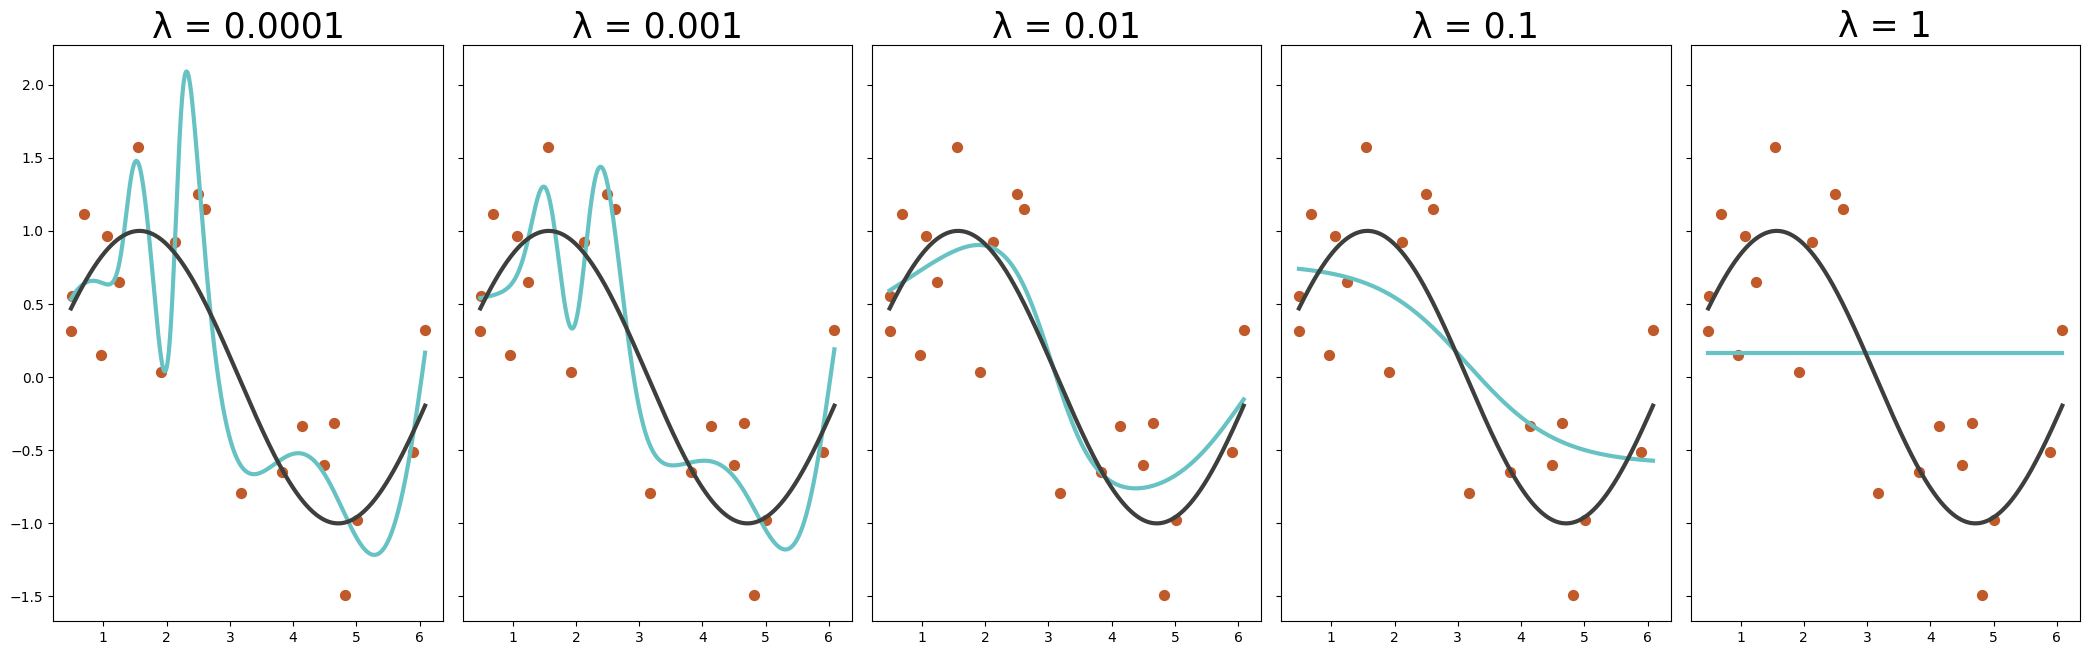

In [28]:
# Prepare plot
fig, axes = plt.subplots(1, 5, figsize=(21, 7), sharex=True, sharey=True)
axes = axes.ravel()

# Set up empty lists to store train + test errors and the norm of the weight vector
train_mses = []
test_mses = []
weight_norms = []

# Loop over the different lambdas (and the individual plot windows)
for ax, lam in zip(axes, lambdas):

    # Instantiate a model
    model = MLP(n_hidden_neurons)
    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Perform model fitting (including the regularization term)
    for epoch in range(epochs):
        preds = model(X_t)
        data_loss = loss_fn(preds, y_t)
        reg_loss = lam * l2_penalty(model, exclude_bias=True)
        loss = data_loss + reg_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate training and out-of-sample performance and compute the sum of squared weights
    with torch.inference_mode():
        model.eval()
        preds_range = model(X_range_t)
        train_mse = loss_fn(model(X_t), y_t).item()
        test_mse = loss_fn(model(X_test_t), y_test_t).item()
        wnorm = torch.sqrt(l2_penalty(model, exclude_bias=True)).item()

    # Save the metrics
    train_mses.append(train_mse)
    test_mses.append(test_mse)
    weight_norms.append(wnorm)
    print(f"λ = {lam:g} -> Test MSE = {test_mse:.4f}")

    # Plot the fit
    ax.plot(X_range_t.squeeze(), preds_range.squeeze(), color='#67C2C4', linewidth=3, label='MLP')
    ax.plot(X_range_t.squeeze(), DGP(X_range_t).squeeze(), color="#3C3F3C", linewidth=3, label='sin(x)')
    ax.scatter(X_train, y_train, color='#C05A2A', s=50, label='data')
    ax.set_title(f"λ = {lam:g}", size=25)

# Finalize plot
handles, labels = axes[0].get_legend_handles_labels()
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

**TASK**: In the code above we used the `l2_penalty` function for educational purposes to implment the $L_2$ regularization. Figure out, how one would do this in practice, when efficiency counts.

Finally, we want to depict the performance of the models using the different $\lambda$ values in- and out-of-sample. What will turn to be very interesting is to inspect the amount of shrinkage that each lambda induces on the weights. We will measure this by: 

$$
\frac{\lVert w(\lambda) \rVert}{\lVert w(0) \rVert}
$$

This will be a measure of model complexity.

**TASK**: Explain the intutition behind this measure. Why is it advantageous to plotting on $\lambda$?

In [29]:
### TASK
# TODO: Fit an unconstrained model (using no shrinkage) and call it 'model_0' using the same hyperparameters as before

In [31]:
# Extract the weight norm
with torch.inference_mode():
    w0 = torch.sqrt(l2_penalty(model0, exclude_bias=True)).item()

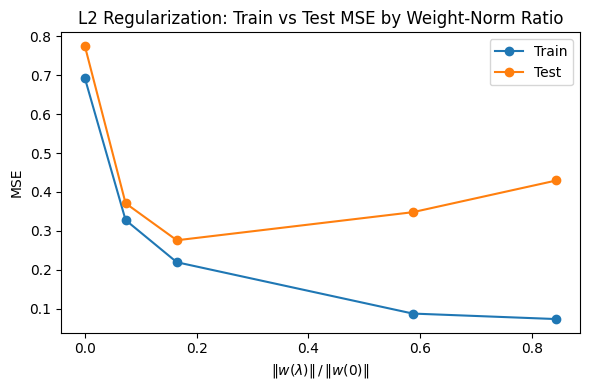

In [32]:
# Plot everything
degree = np.array(weight_norms, dtype=np.float64) / w0
order = np.argsort(degree)

plt.figure(figsize=(6,4))
plt.plot(degree[order], np.array(train_mses)[order], marker='o', label='Train')
plt.plot(degree[order], np.array(test_mses)[order], marker='o', label='Test')
plt.xlabel(r"$\|w(\lambda)\| \,/\, \|w(0)\|$")
plt.ylabel("MSE")
plt.title("L2 Regularization: Train vs Test MSE by Weight-Norm Ratio")
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
### TASK
# TODO: Output the optimal (test error minimizing) lambda